<h1>
    Graph Neural Network in Jax
    </h1>

In [1]:
#This notebook is to run an example jax network
#Will then be modified to take graphs as input. Specifically my fancy space graph (delete this later)

import numpy.random as npr
import jax.numpy as np
from jax import grad

<h2>
    Jax example snippets to help me understand what's happening
    </h2>


In [2]:
#Define Relu
def relu(x):
    return np.maximum(0, x)

relu_grad = grad(relu)


In [3]:
#Can do second order derivatives in JAX
x = 5.0
relu_2nd = grad(relu_grad)

print(relu(x))
print(relu_grad(x))
print(relu_2nd(x))

5.0
1.0
0.0


In [4]:
#Define simple linear model
def linear(params,x):
    w,b = params
    return w*x + b
grad_linear = grad(linear)


w, b = 1.5, 2.
params_grad = grad_linear((w,b),5.0)

In [5]:
#Is this loss?
def loss(params, dataset):
    x, y = dataset
    pred = linear(params, x)
    return np.square(pred - y).mean()

loss_grad = grad(loss)
# (5.0, 2.0) are the made up values for x and y
params_grad = loss_grad((w, b), (5.0, 2.0))


In [6]:
# first generate some random data
X = npr.uniform(0, 1, 300)
true_w, true_b = 2, 1
# add some noise to the labels
Y = X*true_w + true_b + 0.4*npr.randn(300)

In [7]:
iterations = 500
step_size = 0.01
dataset = (X, Y)
w, b = 1.5, 2. # initial values for the parameters
for i in range(iterations):
    params = (w, b)
    loss_ = loss(params, dataset)
    # compute gradient w.r.t model parameters
    params_grad = loss_grad(params, dataset)
    # update parameters
    w -= step_size * params_grad[0]
    b -= step_size * params_grad[1]
    #print(loss_)


<h2>
    Graph Neural Network Construction
    </h2>

In [8]:
#Graph NN

#Define a layer of the network
def Layer():
    def init_fun(*args, **kwargs):
        #init params and compute output shape
        return output_shape, params
    def apply_fun(params, x, *args, **kwargs):
        return out
    

In [9]:
out_dim = 64
def GraphConvolution(out_dim, bias=False):
    """
    Layer constructor function for a Graph Convolution layer 
    as the one in https://arxiv.org/abs/1609.02907
    """
    
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, k2 = random.split(rng)
        W_init, b_init = initializers.glorot_uniform(), initializers.zeros
        W = W_init(k1, (input_shape[-1], out_dim))
        b = b_init(k2, (out_dim,)) if bias else None
        return output_shape, (W, b)

    def apply_fun(params, x, adj, **kwargs):
        W, b = params
        support = np.dot(x, W)
        out = np.matmul(adj, support)
        if bias:
            out += b
        return out

    return init_fun, apply_fun



In [10]:
def GCN(nhid: int, nclass: int, dropout: float):
    """
    This function implements the GCN model that uses 2 Graph Convolutional layers.
    """
    gc1_init, gc1_fun = GraphConvolution(nhid)
    _, drop_fun = Dropout(dropout)
    gc2_init, gc2_fun = GraphConvolution(nclass)

    init_funs = [gc1_init, gc2_init]

    def init_fun(rng, input_shape):
        params = []
        for init_fun in init_funs:
            rng, layer_rng = random.split(rng)
            input_shape, param = init_fun(layer_rng, input_shape)
            params.append(param)
        return input_shape, params

    def apply_fun(params, x, adj, is_training=False, **kwargs):
        rng = kwargs.pop('rng', None)
        k1, k2, k3, k4 = random.split(rng, 4)
        x = drop_fun(None, x, is_training=is_training, rng=k1)
        x = gc1_fun(params[0], x, adj, rng=k2)
        x = nn.relu(x)
        x = drop_fun(None, x, is_training=is_training, rng=k3)
        x = gc2_fun(params[1], x, adj, rng=k4)
        x = nn.log_softmax(x)
        return x
    
    return init_fun, apply_fun


In [11]:
def Dropout(rate):
    """
    Layer construction function for a dropout layer with given rate.
    This Dropout layer is modified from stax.experimental.Dropout, to use
    `is_training` as an argument to apply_fun, instead of defining it at
    definition time.
    Arguments:
        rate (float): Probability of keeping and element.
    """
    def init_fun(rng, input_shape):
        return input_shape, ()
    def apply_fun(params, inputs, is_training, **kwargs):
        rng = kwargs.get('rng', None)
        if rng is None:
            msg = ("Dropout layer requires apply_fun to be called with a PRNG key "
                   "argument. That is, instead of `apply_fun(params, inputs)`, call "
                   "it like `apply_fun(params, inputs, rng)` where `rng` is a "
                   "jax.random.PRNGKey value.")
            raise ValueError(msg)
        keep = random.bernoulli(rng, rate, inputs.shape)
        outs = np.where(keep, inputs / rate, 0)
        # if not training, just return inputs and discard any computation done
        out = lax.cond(is_training, outs, lambda x: x, inputs, lambda x: x)
        return out
    return init_fun, apply_fun

In [12]:
nhid = 2
labels = np.array([[2,2,2,2,2]])
dropout = 0.2

from jax import lax, random
from jax.nn import initializers
rng_key = 2
rng = random.PRNGKey(0)
rng_key, init_key = rng.split(rng_key)



init_fun, predict_fun = GCN(nhid=2, 
                            nclass=2,
                            dropout=dropout)
input_shape = (-1, 40, 40)
rng_key, init_key = rng.split(rng_key)
_, init_params = init_fun(init_key, input_shape)


<h2>
    Create simulation data using NBodyKit
    </h2>

In [13]:

#Create test graph from nbodykit

from src.nn_graph import *
from nbodykit.lab import *
from nbodykit import style, setup_logging
from pmesh.pm import ParticleMesh

redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

BoxSize=1380
nbar=3e-3
bias=1.0
seed=42
nmesh = 256
cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=BoxSize, Nmesh=nmesh, bias=1.0, seed=42)

#should probably make mask here, but don't want to move things around just yet in case of breakage

#extract particle positions from catalogue
mesh = cat.to_mesh(resampler='tsc')
pos = np.array(mesh.Position)
    
#Take small section of the cube for interpretability

size = 40
mask = (pos[:,0]<size)&(pos[:,1]<size)&(pos[:,2]<size)
smallcube = pos[mask,:]

#Extract particle positions
graph = cat_to_graph(cat,4)


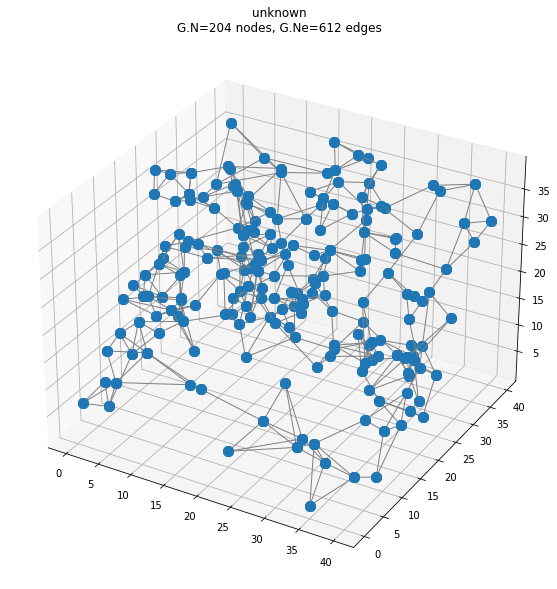

In [14]:
#plot graph

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (20,10)

graph[0].set_coordinates(smallcube)
graph[0].plot()

In [15]:
#Get tidal vectors
from src.tidal_vectors import *
tidals = calculate_tidal_vecs(mesh)

Density painted
Rho computed


Text(0.5, 1.0, 'Tidal Force Vectors against Eigenvector field')

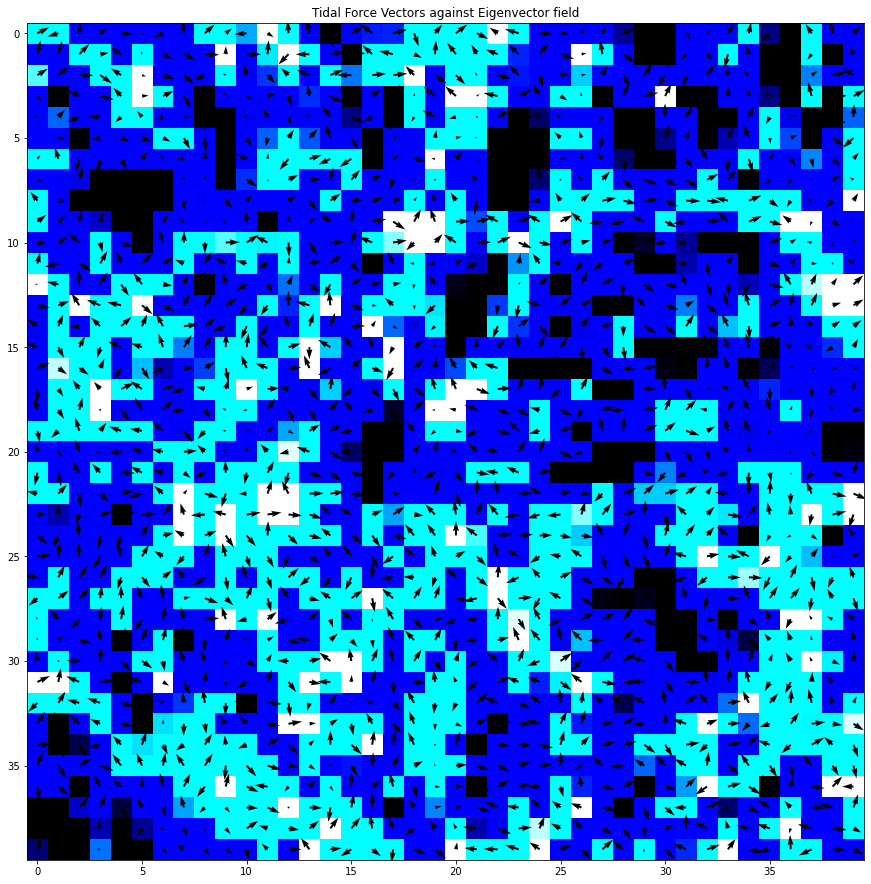

In [17]:

#One of these is our Y value for prediction

cube = tidals[1].reshape([256,256,256,3])
vects =  tidals[2].reshape([256,256,256,3,3])




plt.figure(figsize = (15,215))

plt.quiver(
          vects[0,0:40,0:40,2,0],
          vects[0,0:40,0:40,2,1])
plt.imshow(cube[0,0:40,0:40])
plt.show
plt.title("Tidal Force Vectors against Eigenvector field")

In [ ]:
def loss(params, batch):
    """
    The idxes of the batch indicate which nodes are used to compute the loss.
    """
    inputs, targets, adj, is_training, rng, idx = batch
    preds = predict_fun(params, inputs, adj, is_training=is_training, rng=rng)
    ce_loss = -np.mean(np.sum(preds[idx] * targets[idx], axis=1))
    l2_loss = 5e-4 * optimizers.l2_norm(params)
    return ce_loss + l2_loss


In [ ]:
import jax.experimental.optimizers as opt

opt_init, opt_update, get_params = opt.adam(0.001)
opt_state = opt_init(init_params)


In [ ]:
def update(i, opt_state, batch):
    params = get_params(opt_state)
    return opt_update(i, grad(loss)(params, batch), opt_state)


   <h2> Jraph Graph Tuples </h2>

In [ ]:
graph_tuple = cat_to_graphtuple(cat,4)
graph_tuple

<h2>
    Run Neural Network?
    </h2>

In [ ]:
import time
print("\nStarting training...")

num_epochs = 5
features = 
labels

for epoch in range(num_epochs):
    start_time = time.time()
    # define training batch
    batch = (features, labels, adj, True, rng_key, idx_train)
    # update parameters
    opt_state = update(epoch, opt_state, batch)
    epoch_time = time.time() - start_time

    # validate
    params = get_params(opt_state)
    eval_batch = (features, labels, adj, False, rng_key, idx_val)
    val_acc = accuracy(params, eval_batch)
    val_loss = loss(params, eval_batch)
    print(f"Iter {epoch}/{num_epochs} ({epoch_time:.4f} s) val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

    # new random key at each iteration, othwerwise dropout uses always the same mask 
    rng_key, _ = random.split(rng_key)
